<a href="https://colab.research.google.com/github/nayonsoso/hg-mldl/blob/main/Ch05_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차 검증과 그리드 서치

## 검증 세트 validation set

검증 세트는 말 그대로 모델을 검증하기 위해 사용되는 데이터 세트이다.

이때 '훈련세트가 있는데 검증세트가 왜 필요하지?' 라는 의문을 가질 수 있지만,

모델 검증과 모델 평가는 분리하여 생각해야 한다.

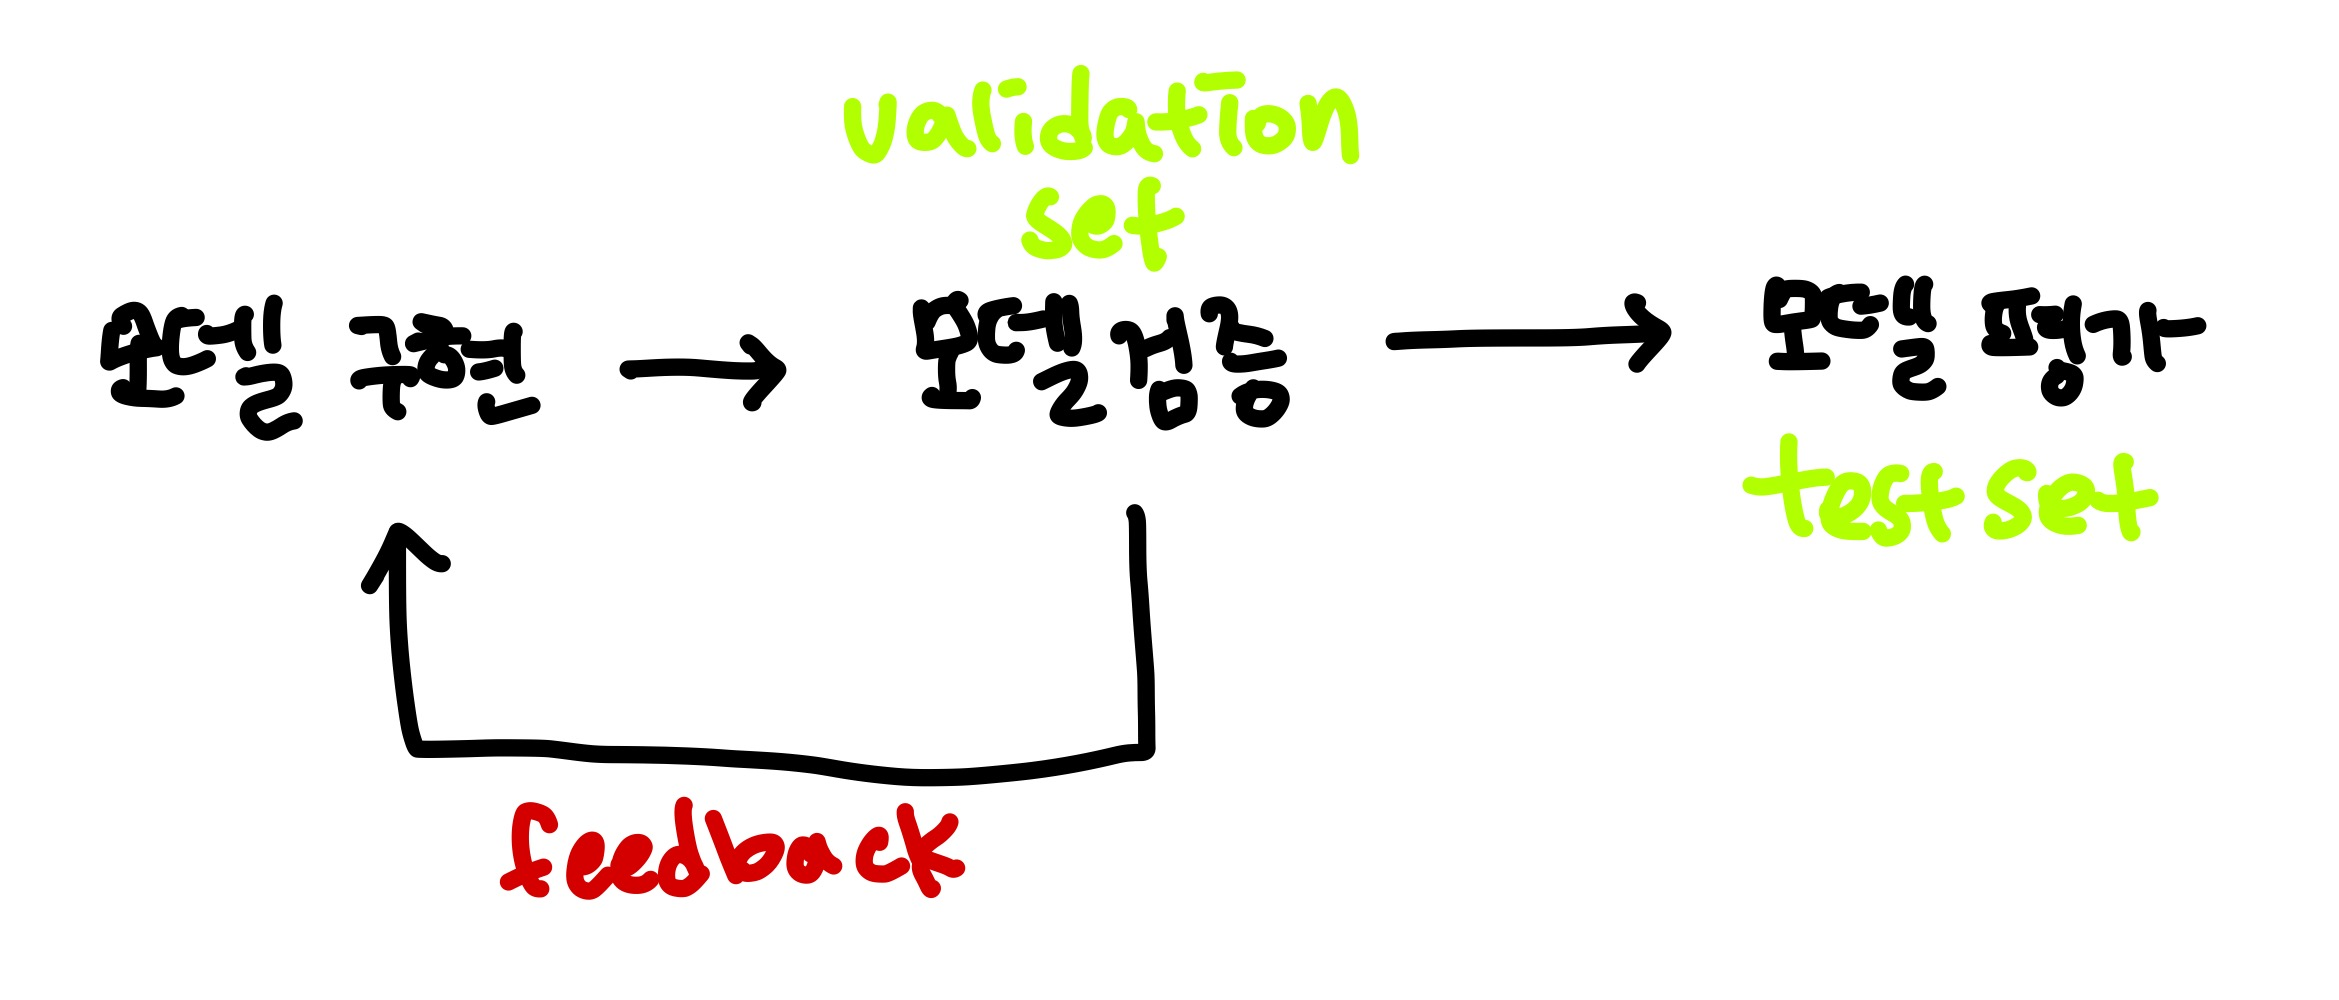

**모델 검증**은 모델 성능을 평가하고, 그 결과를 토대로 모델을 튜닝하는 작업을 진행한다. 

반면 **모델 평가**는 최종적으로 '이 모델이 실전에서 이만큼 성능을 낼 것이다!' 라는 것을 확인하는 단계이다. 

그렇기 때문에 모델 검증 단계와 모델 평가 단계에서 사용하는 데이터셋은 분리되어야한다.

정리하면, Test Set는 모델 튜닝을 모두 마치고 실전에 투입하기 전에 **딱 1번**(모델 평가 단계)만 사용하는 것이 좋다. 

그래서 모델을 튜닝할 때는 별도의 Validation Set을 이용하고, 이는 **훈련 세트를 조금 떼어**서 만든다.

ex. 훈련세트 : 검증세트 : 테스트세트 = 80 : 20 : 20

이미지, 설명 참고 : https://hyjykelly.tistory.com/49

In [12]:
# 판다스로 csv 데이터 읽어오기
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

# csv 데이터 head 를 기준으로 데이터(=X), 타겟(=Y) 분류
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [13]:
# 훈련 세트, 테스트 세트 분류
from sklearn.model_selection import train_test_split

# test_size=0.2로 전체 데이터에서 테스트 세트 비율 설정
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

# train_set : test_set = 0.8 : 0.2 임을 확인
print("train_input :\t",train_input.shape,
      "\ntest_input :\t",test_input.shape,
      "\ntrain_target :\t",train_target.shape,
      "\ntest_target :\t",test_target.shape)

train_input :	 (5197, 3) 
test_input :	 (1300, 3) 
train_target :	 (5197,) 
test_target :	 (1300,)


In [14]:
# 훈련세트를 다시 sub_set과 val_set으로 분류
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [15]:
# sub : val : test = 0.64 : 0.16 : 0.2
print("sub_input :\t",sub_input.shape,
      "\nval_input :\t",val_input.shape,
      "\nsub_target :\t",sub_target.shape,
      "\nval_target :\t",val_target.shape)

sub_input :	 (4157, 3) 
val_input :	 (1040, 3) 
sub_target :	 (4157,) 
val_target :	 (1040,)


In [16]:
# 결정 트리 모델 이용
from sklearn.tree import DecisionTreeClassifier

# 모델 훈련
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

# sub 점수
print(dt.score(sub_input, sub_target))

# val 점수
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


validation set로 검증해본 결과,

sub(훈련세트)의 평가 점수보다 val(검증세트)의 평가점수가 더 낮으므로 

과대적합이 일어났다는 것을 알 수 있다.

## 교차 검증 cross validation

머신러닝 모델은 학습 데이터가 많을 수록 정교하게 학습하는데, 

훈련 세트의 일부를 검증 세트로 이용하면 학습에 사용할 수 있는 데이터가 줄어들기 때문에 위와 같은 문제가 발생할 수 있다.

또 고정된 검증 세트를 이용하면 실제 데이터가 아닌 검증 세트에만 과대 적합될 수 있다는 문제도 발생한다.

이를 해결하기 위해 **교차 검증**을 이용한다.

교차 검증은 검증세트를 떼어 평가하는 과정을 여러 번 반복한다.

대표적으로 훈련세트를 k등분하여 교차검증을 수행하는 **k-폴드** 방식이 있다.

교차 검증을 이용하면 대부분의 데이터를 훈련에 사용할 수 있다는 장점이 있지만,

그만큼 오랜 시간이 걸린다는 단점이 있다.

참고 : https://en.wikipedia.org/wiki/Cross-validation_(statistics)#/media/File:LOOCV.gif

사이킷 런은 교차 검증 라이브러리 cross_validation을 제공한다.

cross_validation 객체를 생성할 때 매개변수로 (모델 객체, 훈련 인풋, 훈련 타겟)을 넣어주면

디폴트로 5-폴드 교차 검증을 진행하며 각각의 검증에 걸린 훈련 시간, 검증 시간, 검증의 점수을 딕셔너리로 반환한다.

In [17]:
# 사이킷 런에서 제공하는 교차 검증 라이브러리 - cross_validation
from sklearn.model_selection import cross_validate

# cross_validate(모델 객체, 훈련 인풋, 훈련 타겟)
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00889111, 0.00710058, 0.00845313, 0.00752854, 0.00723028]), 'score_time': array([0.00088072, 0.0006938 , 0.00089931, 0.0007596 , 0.00072026]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


교차 검증의 최종 점수는 반환된 딕셔너리에서 'test_score'의 평균으로 구할 수 있다.

In [18]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


cross_validate 자체로는 훈련세트를 섞지 않고 데이터를 분할하기 때문에 

cross_validate 객체에 'cv = StratifiedKFold()' 옵션을 추가하여 섞어줘야 한다.

앞에서 실행한 k-fold는 이미 train_test_split로 섞인 데이터를 이용했기 때문에 이 과정을 생략했지만,

대부분의 경우 아래와 같이 cv = StratifiedKFold()를 이용해 훈련데이터를  섞어준다.

In [19]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [20]:
# 훈련세트를 섞은 후 10-폴드 교차검증
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8574181117533719


## 하이퍼파라미터 튜닝

모델이 학습할 수 있는 파라미터를 모델 파라미터, 

모델이 학습할 수 없어 사용자가 지정해야하는 파라미터를 하이퍼 파라미터라고 한다. (복습 : Ch03-2)


그럼 이 하이퍼 파라미터를 어떤 기준으로 정해야 할까?

먼저 모델의 라이브러리가 디폴트로 제공하는 값을 이용하여 훈련하고

이후 검증 세트의 점수나 교차검증을 통해 매개변수를 바꿀 수 있다.

이때, 주의할 점은 **전체 하이퍼 파라미터를 동시에 튜닝**해야 한다는 점이다.

어떤 모델의 성능은 하이퍼 파라미터 하나가 영향을 주는 것이라 아닌 전체 파라미터가 영향을 주는 것이므로,

하이퍼 파라미터의 최적값을 찾기 위해선 여러 파라미터를 동시에 바꿔가야 한다.

사이킷 런에서는 하이퍼 파라키터 탐색과 교차검증을 한번에 수행하는 **GridSearchCV** 라이브러리를 제공한다.

우선 결정 트리 모델에서 min_impurity_decrease(최소 불순도) 하이퍼 파라미터의 최적값을 찾아보자.

cf. 결정 트리 모델 참고 : https://inuplace.tistory.com/548

In [21]:
from sklearn.model_selection import GridSearchCV

# 딕셔너리 형태의 하이퍼 파라미터
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

# GridSearchCV에 결정 트리 모델, 하이퍼 파라미터, n_jobs를 매개변수로 전달
# GridSearchCV는 디폴트로 5-폴드 교차 검증을 하므로
# 5개의 파라미터마다 5번의 교차 검증 즉, 25번의 훈련을 실행함
# -> n_jobs=-1 로 시스템의 모든 코어를 사용하게 설정
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

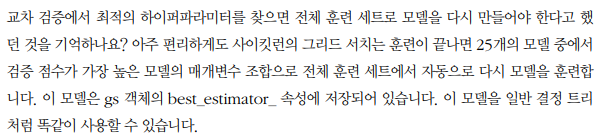

뭐요?

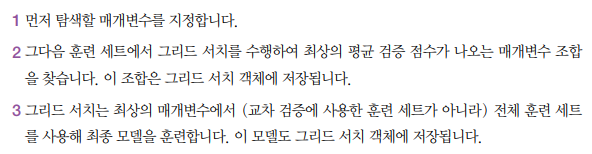

최적의 파라미터가 저장된 상태에서 전체 훈련세트를 이용해 최종 모델을 훈련한다매
근데 왜 굳이 코드를 이용해 다시 전체 데이터를 학습시기키는거지?

In [23]:
gs.fit(train_input, train_target)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
    

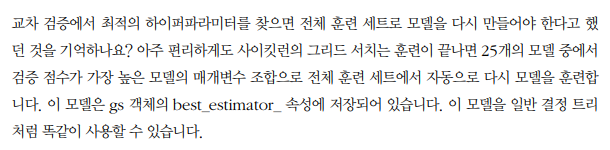

그런말 안했는데여;; 그리고 아 모르겠다 ㅠ

In [24]:
# 최적의 하이퍼 파라미터를 갖으며 전체 훈련 데이터를 훈련시킨 모델 - best_estimator_
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [25]:
# 최적의 하이퍼 파라미터 조합 - best_params_
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [26]:
# 파라미터 별 교차 검정 점수 - mean_test_score
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [27]:
# numpy 배열에서 최대값 찾기 - argmax
best_index = np.argmax(gs.cv_results_['mean_test_score'])

# 교차 검정 점수가 가장 높은 파라미터와 gs.best_params_로 찾은 파라미터가 동일한지 확인
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


세개의 하이퍼 파라미터 

- min_impurity_decrease (최소 불순도)
- max_depth (최대 깊이)
- min_samples_split (자식 노드를 분할하는데 필요한 최소 샘플 수)

의 최적 조합을 같은 방법으로 구해보자.

In [28]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

          # min_impurity_decrease = [0.0001 0.0002 ... 0.0009]
          # max_depth = [5 6 7 ... 19]
          # min_samples_split = [2 12 22 ... 92]
          # 각각 9, 15, 10개가 있으므로 총 9*15*10 = 1350 번의 교차검증을 한다.

In [29]:
# 모델, 파라미터 전달하여 gs 객체 만들기
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

# 전체 훈련세트로 훈련
gs.fit(train_input, train_target)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'm

In [30]:
# 최적의 하이퍼 파라미터 조합
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [31]:
# 최적의 조합일 때 교차 검증 점수
print(np.max(gs.cv_results_['mean_test_score']))
# 조금.. 낮지 않나..?

0.8683865773302731


### 랜덤 서치

위의 방법을 이용하면 주어진 파라미터에서 최적의 조합을 찾을 수 있다.

하지만 파라미터 범위를 설정한 특별한 근거가 존재하지 않는다.

이처럼 파라미터의 기준을 정하기 어려울 때 랜덤 서치를 이용할 수 있다.

### 정규 분포에서 랜덤하게 추출하는 라이브러리 uniform,

In [32]:
from scipy.stats import uniform, randint

In [33]:
rgen = randint(0, 10)
rgen.rvs(10)

array([4, 0, 6, 4, 0, 3, 6, 9, 9, 8])

In [34]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([101,  93,  96,  87, 104,  96, 107,  98, 104, 114]))

In [35]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.51222225, 0.06574113, 0.24224831, 0.20837319, 0.28545181,
       0.89958117, 0.33507763, 0.2366988 , 0.87082945, 0.65824422])

### 난수 생성기를 이용해 랜덤 서치

1. 파라미터 딕셔너리에 난수 생성기 전달
2. RandomizedSearchCV 라이브러리로 객체 생성
3. n_iter 옵션으로 랜덤 파라미터를 몇 번 샘플링할지 지정

ex. n_iter = 100 이면 100개의 난수 조합을 추출하여 교차 검증

In [36]:
# 파라미터 딕셔너리에 난수 생성기 전달
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [37]:
# RandomizedSearchCV 라이브러리로 객체 생성
from sklearn.model_selection import RandomizedSearchCV

# n_iter 옵션으로 랜덤 파라미터를 몇 번 샘플링할지 지정
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)

# 전체 훈련세트로 훈련
gs.fit(train_input, train_target)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
         

In [38]:
# 최적의 하이퍼 파라미터 조합
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [39]:
# 최적의 조합일 때 교차 검증 점수
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [40]:
# 최적의 조합을 갖고 전체 훈련세트도 훈련한 모델
dt = gs.best_estimator_

# 테스트 세트 점수
print(dt.score(test_input, test_target))

0.86


복습할 때 문제 해결과정 한번만 더 읽어보자
& 마무리도! 

## 확인문제

In [41]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params, 
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
         

In [42]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
